In [3]:
import torchio as tio
from torchio.data.io import sitk_to_nib
import SimpleITK as sitk
import napari

from classes.SAMMed3DClass import SAMMed3DWrapper, SAMMed3DInferer
from utils.modelUtils import load_sammed3d
from utils.promptUtils import get_pos_clicks3D
import utils.analysisUtils as anUt

from utils.imageUtils import read_im_gt


In [4]:
def get_img_gt_sammed3d(img_path, gt_path):    
    infer_transform = [
        tio.ToCanonical(),
    ]
    transform = tio.Compose(infer_transform)

    sitk_image = sitk.ReadImage(img_path)
    sitk_label = sitk.ReadImage(gt_path)

    if sitk_image.GetOrigin() != sitk_label.GetOrigin():
        sitk_image.SetOrigin(sitk_label.GetOrigin())
    if sitk_image.GetDirection() != sitk_label.GetDirection():
        sitk_image.SetDirection(sitk_label.GetDirection())

    sitk_image_arr, _ = sitk_to_nib(sitk_image)
    sitk_label_arr, _ = sitk_to_nib(sitk_label)

    subject = tio.Subject(
        image = tio.ScalarImage(tensor=sitk_image_arr),
        label = tio.LabelMap(tensor=sitk_label_arr),
    )

    if transform:
        subject = transform(subject)

    return subject.image.data.clone().detach().squeeze().numpy(), subject.label.data.clone().detach().squeeze().numpy()


In [5]:
# Obtain model, image, gt
device = 'cuda'
sammed3d_checkpoint_path = '/home/t722s/Desktop/UniversalModels/TrainedModels/sam_med3d_turbo.pth'

sam_model_tune = load_sammed3d(sammed3d_checkpoint_path, device = device)
wrapper = SAMMed3DWrapper(sam_model_tune, device)
inferer = SAMMed3DInferer(wrapper)

img_path = '/home/t722s/Desktop/Datasets/preprocessed/spleen/AbdomenAtlasJHU_2img/imagesTr/BDMAP_00000001.nii.gz'
gt_path = '/home/t722s/Desktop/Datasets/preprocessed/spleen/AbdomenAtlasJHU_2img/labelsTr/BDMAP_00000001.nii.gz'
img, gt = get_img_gt_sammed3d(img_path, gt_path)
#img, gt = read_im_gt(img_path, gt_path)

In [6]:

# Experiment: 5 points per volume
seed = 2024
n = 5
pts_prompt = get_pos_clicks3D(gt, n, seed = seed)

#pred = inferer.predict(img, pts_prompt, cheat = True, gt = gt)
segmentation = inferer.predict(img, pts_prompt)

anUt.compute_dice(segmentation, gt)

0.6783242594814063

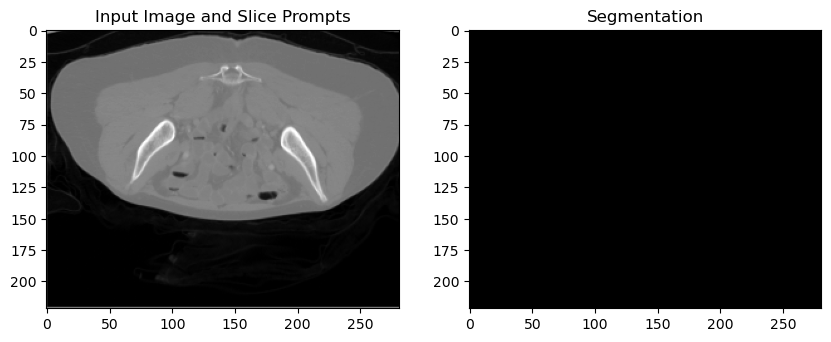

nan

In [7]:
# Visualise segmentation slice-wise
slice_idx = 110
anUt.show_seg_row_major(slice_idx, img, gt, segmentation, pts_prompt = pts_prompt)

In [8]:
# Visualise with napari
viewer = napari.Viewer()

# Change label on segmentation for distinction
from copy import deepcopy
seg_vis = deepcopy(segmentation)
seg_vis[seg_vis == 1] = 2

viewer.add_image(img, name='Image')

viewer.add_labels(seg_vis, name='Segmentation', opacity=0.6)
viewer.add_labels(gt, name='Ground Truth', opacity=0.6)

# Run the napari viewer
napari.run()
